# Comparing DAN and GRU


## Imports


In [ ]:
# fix colab utf-8 error
import locale


def getpreferredencoding(do_setlocale=True):
    return "UTF-8"


locale.getpreferredencoding = getpreferredencoding

# inbuilt lib imports:
from collections import Counter
from typing import List, Dict, Tuple, Any
import json
import os
import zipfile
import random
import requests
import io

# external lib imports:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import spacy
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.tensorboard.writer import SummaryWriter

import copy

# NLP library with many language related datasets and functions
nlp = spacy.load("en_core_web_sm", disable=["ner", "tagger", "parser", "textcat"])

np.random.seed(1337)
torch.manual_seed(1337)

try:
    from google.colab import drive
    drive.mount("/content/drive", force_remount=True)
    %cd "/content/drive/MyDrive/M4L/dan-gru"
except:
    pass

## Datasets


We use two classification datasets stored in `data/`:

1. **IMDB Sentiment:** A sample of the original dataset, which has annotations on whether the IMDB review is positive or negative. In our preprocessed version, positive is labeled 1 and negative 0. There are dev and several test sets.

2. **Bigram Order:** A binary classification of whether a bigram is in the correct order or reversed. For example, `New York` is 1 and `York New` 0. It's in the same format as the IMDB sentiment dataset. There are train, dev, and test sets.

We will read and index the dataset, generate and manage the vocabulary, load the embedding files, and generate batches.


In [ ]:
def read_instances(
    data_file_path: str, max_allowed_num_tokens: int = 150
) -> List[Dict]:
    """
    Reads raw classification dataset from a file and returns a list
    of dicts where each dict defines an instance.

    @param data_file_path: path to the file containing the dataset
    @param max_allowed_num_tokens: maximum allowed number of tokens in an instance
    """
    instances = []
    with open(data_file_path) as file:
        for line in tqdm(file.readlines()):
            instance = json.loads(line.strip())
            text = instance["text"]
            tokens = [token.text.lower() for token in nlp.tokenizer(text)][
                :max_allowed_num_tokens
            ]
            instance["labels"] = instance.pop("label", None)
            instance["text_tokens"] = tokens
            instance.pop("text")
            instances.append(instance)
    return instances


def build_vocabulary(
    instances: List[Dict], vocab_size: int, add_tokens: List[str]
) -> Tuple[Dict, Dict]:
    """
    Given the instances and max vocab size, this function builds the
    token to index and index to token vocabularies. If list of add_tokens are
    passed, those words will be added first.

    @param instances: list of dicts where each dict defines an instance
    @param vocab_size: maximum allowed size of the vocabulary
    @param add_tokens: list of tokens to be added to the vocabulary
    """
    print("\nBuilding Vocabulary.")

    # make sure pad_token is on index 0
    UNK_TOKEN = "@UNK@"
    PAD_TOKEN = "@PAD@"
    token_to_id = {PAD_TOKEN: 0, UNK_TOKEN: 1}

    # First add tokens which were explicitly passed.
    add_tokens = add_tokens or []
    for token in add_tokens:
        if not token.lower() in token_to_id:
            token_to_id[token] = len(token_to_id)

    # Add remaining tokens from the instances as the space permits
    words = []
    for instance in instances:
        words.extend(instance["text_tokens"])
    token_counts = dict(Counter(words).most_common(vocab_size))
    for token, _ in token_counts.items():
        if token not in token_to_id:
            token_to_id[token] = len(token_to_id)
        if len(token_to_id) == vocab_size:
            break
    # Make reverse vocabulary lookup
    id_to_token = dict(zip(token_to_id.values(), token_to_id.keys()))
    return (token_to_id, id_to_token)


def save_vocabulary(vocab_id_to_token: Dict[int, str], vocabulary_path: str) -> None:
    """
    Saves vocabulary to vocabulary_path.

    @param vocab_id_to_token: index to token mapping
    @param vocabulary_path: path to save the vocabulary
    """
    with open(vocabulary_path, "w", encoding="utf-8") as file:
        # line number is the index of the token
        for idx in range(len(vocab_id_to_token)):
            file.write(vocab_id_to_token[idx] + "\n")


def load_vocabulary(vocabulary_path: str) -> Tuple[Dict[str, int], Dict[int, str]]:
    """
    Loads vocabulary from vocabulary_path.

    @param vocabulary_path: path to load the vocabulary
    """
    vocab_id_to_token = {}
    vocab_token_to_id = {}
    with open(vocabulary_path, "r", encoding="utf-8") as file:
        for index, token in enumerate(file):
            token = token.strip()
            if not token:
                continue
            vocab_id_to_token[index] = token
            vocab_token_to_id[token] = index
    return (vocab_token_to_id, vocab_id_to_token)


def load_glove_embeddings(
    embeddings_txt_file: str, embedding_dim: int, vocab_id_to_token: Dict[int, str]
) -> np.ndarray:
    """
    Given a vocabulary (mapping from index to token), this function builds
    an embedding matrix of vocabulary size in which ith row vector is an
    entry from pretrained embeddings (loaded from embeddings_txt_file).

    @param embeddings_txt_file: path to the file containing pretrained embeddings
    @param embedding_dim: dimension of the pretrained embeddings
    @param vocab_id_to_token: index to token mapping
    """
    tokens_to_keep = set(vocab_id_to_token.values())
    vocab_size = len(vocab_id_to_token)

    embeddings = {}
    print("\nReading pretrained embedding file.")
    with open(embeddings_txt_file, encoding="utf-8") as file:
        for line in tqdm(file):
            line = str(line).strip()
            token = line.split(" ", 1)[0]
            if not token in tokens_to_keep:
                continue
            fields = line.rstrip().split(" ")
            if len(fields) - 1 != embedding_dim:
                raise Exception(
                    f"Pretrained embedding vector and expected "
                    f"embedding_dim do not match for {token}."
                )
                continue
            vector = np.asarray(fields[1:], dtype="float32")
            embeddings[token] = vector

    # Estimate mean and std variation in embeddings and initialize it random normally with it
    all_embeddings = np.asarray(list(embeddings.values()))
    embeddings_mean = float(np.mean(all_embeddings))
    embeddings_std = float(np.std(all_embeddings))

    embedding_matrix = np.random.normal(
        embeddings_mean, embeddings_std, (vocab_size, embedding_dim)
    )
    embedding_matrix = np.asarray(embedding_matrix, dtype="float32")

    for idx, token in vocab_id_to_token.items():
        if token in embeddings:
            embedding_matrix[idx] = embeddings[token]

    return embedding_matrix


def index_instances(instances: List[Dict], token_to_id: Dict) -> List[Dict]:
    """
    Uses the vocabulary to index the fields of the instances. This function
    prepares the instances to be tensorized.

    @param instances: list of dicts where each dict defines an instance
    @param token_to_id: token to index mapping
    """
    for instance in instances:
        token_ids = []
        for token in instance["text_tokens"]:
            if token in token_to_id:
                token_ids.append(token_to_id[token])
            else:
                token_ids.append(1)  # 1 is index for UNK
        instance["text_tokens_ids"] = token_ids
        instance.pop("text_tokens")
    return instances


def generate_batches(instances: List[Dict], batch_size) -> List[Dict[str, np.ndarray]]:
    """
    Generates and returns batch of tensorized instances in a chunk of batch_size.

    @param instances: list of dicts where each dict defines an instance
    @param batch_size: size of the batch
    """

    def chunk(items: List[Any], num: int):
        return [items[index : index + num] for index in range(0, len(items), num)]

    # Create padded instances list to make sure all batches are of same size
    padded_instances = instances[:]
    num_missing = (batch_size - len(instances) % batch_size) % batch_size
    padded_instances += [
        {
            "text_tokens_ids": instances[index % len(instances)]["text_tokens_ids"],
            "padding": True,
        }
        for index in range(num_missing)
    ]

    # Create batches of instances
    batches_of_instances = chunk(padded_instances, batch_size)

    batches = []
    for batch_of_instances in tqdm(batches_of_instances):
        num_token_ids = [
            len(instance["text_tokens_ids"]) for instance in batch_of_instances
        ]
        max_num_token_ids = max(num_token_ids)

        count = min(batch_size, len(batch_of_instances))
        batch = {"inputs": np.zeros((count, max_num_token_ids), dtype=np.int32)}
        if "labels" in batch_of_instances[0]:
            batch["labels"] = np.zeros(count, dtype=np.int32)

        for batch_index, instance in enumerate(batch_of_instances):
            num_tokens = len(instance["text_tokens_ids"])
            inputs = np.array(instance["text_tokens_ids"])
            batch["inputs"][batch_index][:num_tokens] = inputs

            if "labels" in instance:
                batch["labels"][batch_index] = np.array(instance["labels"])
        batches.append(batch)

    return batches

In [ ]:
r = requests.get("https://zenodo.org/records/4925376/files/glove.6B.50d.zip?download=1")
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall("data")

# Data paths
imdb_sentiment_dev_path = "data/imdb_sentiment_dev.jsonl"
imdb_sentiment_train_5k_path = "data/imdb_sentiment_train_5k.jsonl"
imdb_sentiment_train_10k_path = "data/imdb_sentiment_train_10k.jsonl"
imdb_sentiment_train_15k_path = "data/imdb_sentiment_train_15k.jsonl"
imdb_sentiment_test_path = "data/imdb_sentiment_test.jsonl"

bigram_order_train_path = "data/bigram_order_train.jsonl"
bigram_order_dev_path = "data/bigram_order_dev.jsonl"
bigram_order_test_path = "data/bigram_order_test.jsonl"

pretrained_embedding_path = "data/glove.6B.50d.txt"

## Models


There are two kinds of models in this notebook: main and probing.

- The main model is a simple classifier which can be instantiated using either DAN or GRU sequence encoders.

- The probing model is built on top of a pretrained main model. It takes frozen representations from nth layer of a pretrained main model and then trains a classifier using those representations.

Probing is a method that tests the amount of information flowing from one layer to another in a neural network model. For example, if we have a 4 layer model and want to test the amount of information flowing from the second layer to the third layer, then we must take all the outputs from the second layer that are going to the third layer and test if they have sufficient information for the classification task. Thus, these outputs from the second layer are sent into a linear classifier that is trained to perform the classification. Linear probes that perform well on a given layer indicate that the underlying layers have extracted enough information from the data for the classification task.


In [ ]:
class SequenceToVector(nn.Module):
    """
    This is an abstract class defining the SequenceToVector encoder.
    """

    def __init__(self, input_dim: int):
        """
        @param input_dim: Last dimension of the input input vector sequence that
                          this SentenceToVector encoder will encounter.
        """
        super(SequenceToVector, self).__init__()
        self._input_dim = input_dim

    def forward(
        self, vector_sequence: torch.Tensor, sequence_mask: torch.Tensor, training=False
    ) -> Dict[str, torch.Tensor]:
        """
        Forward pass of Main Classifier. It returns a single final vector (combined_vector) for each input sentence but also
        the intermediate representation vectors from each feedforward layer (layer_representations).

        @param vector_sequence: Sequence of embedded vectors of shape (batch_size, max_tokens_num, embedding_dim)
        @param sequence_mask: Boolean tensor of shape (batch_size, max_tokens_num). Entries with 1 indicate that
                              token is a real token, and 0 indicate that it's a padding token.
        @param training: Whether this call is in training mode or prediction mode.
        """
        raise NotImplementedError


class DanSequenceToVector(SequenceToVector):
    def __init__(
        self,
        input_dim: int,
        num_layers: int,
        dropout: float = 0.2,
        device="cuda" if torch.cuda.is_available() else "cpu",
    ):
        super(DanSequenceToVector, self).__init__(input_dim)
        self.layers = nn.ModuleList()
        self.dropout = nn.Dropout(p=dropout)

        for i in range(num_layers - 1):
            self.layers.append(nn.Linear(input_dim, input_dim))
            # self.layers.append(self.dropout)

        self.layers.append(nn.Linear(input_dim, input_dim, bias=False))

        self.to(device)

    def forward(
        self, vector_sequence: torch.Tensor, sequence_mask: torch.Tensor, training=False
    ):
        """
        This DAN implementation outputs a single final vector (combined_vector) for each input sentence but also
        the intermediate representation vectors from each feedforward layer (layer_representations).

        DAN first computes the average of the embeddings of the words in the input sentence.
        Then, this average is passed through given number of feed-forward layers.
        The intermediate vectors are needed for other analysis later.
        The final vector is used for classification.

        @param vector_sequence: Sequence of embedded vectors of shape (batch_size, max_tokens_num, embedding_dim)
        @param sequence_mask: Boolean tensor of shape (batch_size, max_tokens_num). Entries with 1 indicate that
                                token is a real token, and 0 indicate that it's a padding token.
        @param training: Whether this call is in training mode or prediction mode.
        """
        if training:
            vector_sequence = self.dropout(vector_sequence)
        combined_vector = torch.sum(vector_sequence, dim=1)
        combined_vector = combined_vector / torch.sum(sequence_mask, dim=1).unsqueeze(1)
        combined_vector = torch.nan_to_num(
            combined_vector, nan=0.0, posinf=0.0, neginf=0.0
        )

        layer_representations = []
        for i, layer in enumerate(self.layers):
            combined_vector = layer(combined_vector)
            if (
                i != len(self.layers) - 1
            ):  # Apply ReLU activation to the first n-1 layers
                combined_vector = F.relu(combined_vector)
            layer_representations.append(combined_vector)

        return {
            "combined_vector": combined_vector,
            "layer_representations": torch.stack(layer_representations, dim=1),
        }


class GruSequenceToVector(SequenceToVector):
    def __init__(
        self,
        input_dim: int,
        num_layers: int,
        device="cuda" if torch.cuda.is_available() else "cpu",
    ):
        super(GruSequenceToVector, self).__init__(input_dim)
        self.gru = nn.GRU(input_dim, input_dim, num_layers=num_layers, batch_first=True)
        self.to(device)

    def forward(
        self, vector_sequence: torch.Tensor, sequence_mask: torch.Tensor, training=False
    ):
        # Find the sequence lengths based on the sequence_mask and use it to pack the padded sequence that is passed to the GRU
        sequence_lengths = sequence_mask.sum(dim=1)
        packed_input = nn.utils.rnn.pack_padded_sequence(
            vector_sequence,
            sequence_lengths.cpu(),
            batch_first=True,
            enforce_sorted=False,
        )
        packed_output, hidden_states = self.gru(packed_input)

        # Unpack the output to obtain the output tensor and the last hidden state
        output, _ = nn.utils.rnn.pad_packed_sequence(packed_output, batch_first=True)
        combined_vector = output[
            torch.arange(output.size(0)), (sequence_lengths - 1).long()
        ]

        # Stack the hidden states
        layer_representations = hidden_states.permute(1, 0, 2)

        return {
            "combined_vector": combined_vector,
            "layer_representations": layer_representations,
        }


class ProbingClassifier(nn.Module):
    def __init__(
        self,
        pretrained_model_path: str,
        layer_num: int,
        input_dim: int,
        classes_num: int,
        device: str = "cuda" if torch.cuda.is_available() else "cpu",
    ):
        """
        It loads a pretrained main model. On the given input, it takes
        the representations it generates on certain layer and learns a
        linear classifier on top of these frozen features.

        @param pretrained_model_path: path to the pretrained model
        @param layer_num: layer number from which to extract the representations
        @param input_dim: input dimension of the probing classifier
        @param classes_num: number of classes in the classification task
        @param device: device to run the probing classifier on
        """
        super(ProbingClassifier, self).__init__()
        self.device = device

        self._pretrained_model = load_pretrained_model(
            pretrained_model_path, device=device
        ).to(device)
        for param in self._pretrained_model.parameters():
            param.requires_grad = False
        self._layer_num = layer_num
        self.device = device

        # Initialize the linear probing layer
        self.probing_layer = nn.Linear(input_dim, classes_num)

    def forward(self, inputs: torch.Tensor, training: bool = False):
        inputs = inputs.to(self.device)
        """
        Forward pass of Probing Classifier.

        @param inputs: input tensor of shape (batch_size, max_tokens_num)
        @param training: Whether this call is in training mode or prediction mode.
        """

        # Forward pass through the pretrained model
        with torch.no_grad():
            output = self._pretrained_model(inputs, training=training)

        # Extract the layer representations and apply the linear probe on them
        layer_representations = output["layer_representations"][self._layer_num]
        logits = self.probing_layer(layer_representations)

        return {"logits": logits}

## Training and Testing Framework


Functions for training, saving, and evaluating the models.


In [ ]:
def cross_entropy_loss(logits, labels):
    # Make sure that the parameters are of the correct type and shape
    logits = logits.to(torch.float32)
    labels = labels.to(torch.int64)
    min_batch_size = min(logits.size(0), labels.size(0))
    logits = logits[:min_batch_size]
    labels = labels[:min_batch_size]
    return nn.CrossEntropyLoss()(logits, labels)


class MainClassifier(nn.Module):
    def __init__(
        self,
        seq2vec_choice: str,
        vocab_size: int,
        embedding_dim: int,
        num_layers: int = 2,
        num_classes: int = 2,
        device: str = "cuda" if torch.cuda.is_available() else "cpu",
    ):
        """
        Wrapper model for DAN or GRU sentence encoder.
        We define the trainable variables in the initializer.

        @param seq2vec_choice: choice of sequence to vector layer. It can be either
            "dan" or "gru".
        @param vocab_size: size of the vocabulary
        @param embedding_dim: dimension of the word embeddings
        @param num_layers: number of layers in the sequence to vector layer
        @param num_classes: number of classes in the classification task
        @param device: device to store the model and tensors
        """
        super(MainClassifier, self).__init__()
        self.device = device

        if seq2vec_choice == "dan":
            self._seq2vec_layer = DanSequenceToVector(
                embedding_dim, num_layers, device=device
            ).to(device)
        else:
            self._seq2vec_layer = GruSequenceToVector(
                embedding_dim, num_layers, device=device
            ).to(device)

        # Trainable Variables
        torch.manual_seed(42)
        self._embedding_layer = nn.Embedding(vocab_size, embedding_dim).to(device)
        self._classification_layer = nn.Linear(embedding_dim, num_classes).to(device)

    def forward(self, inputs, training=False):
        """
        Forward pass of Main Classifier.

        @param inputs: batch of input tensors
        @param training: whether the model is in training mode
        """
        inputs = inputs.to(self.device)
        embedded_tokens = self._embedding_layer(inputs)
        tokens_mask = torch.where(inputs != 0, 1, 0).float()
        outputs = self._seq2vec_layer(embedded_tokens, tokens_mask, training)
        classification_vector = outputs["combined_vector"]
        layer_representations = outputs["layer_representations"]
        logits = self._classification_layer(classification_vector)
        return {"logits": logits, "layer_representations": layer_representations}


def load_pretrained_model(
    serialization_dir: str,
    device: str | torch.device = "cuda" if torch.cuda.is_available() else "cpu",
) -> nn.Module:
    """
    Given serialization directory, returns: model loaded with the pretrained weights.

    @param serialization_dir: path to the serialization directory
    @param device: device to store the model and tensors
    """

    # Load Config
    config_path = os.path.join(serialization_dir, "config.json")
    model_path = os.path.join(serialization_dir, "model.pkg")

    model_files_present = all(
        [os.path.exists(path) for path in [config_path, model_path]]
    )
    if not model_files_present:
        raise Exception(
            f"Model files in serialization_dir ({serialization_dir}) "
            f" are missing. Cannot load_the_model."
        )

    with open(config_path, "r") as file:
        config = json.load(file)
    config["device"] = device
    # Load Model
    model_name = config.pop("type")
    if model_name == "main":
        model = MainClassifier(**config)
        state = torch.load(model_path, map_location=device)
        model.load_state_dict(state["model"])
    else:
        model = ProbingClassifier(**config)
        state = torch.load(model_path, map_location=device)
        model.load_state_dict(state["model"])

    return model


def train(
    model: nn.Module,
    optimizer: torch.optim.Optimizer,
    train_instances: List[Dict[str, np.ndarray]],
    validation_instances: List[Dict[str, np.ndarray]],
    num_epochs: int,
    batch_size: int,
    serialization_dir: str | None = None,
    device: str = "cuda" if torch.cuda.is_available() else "cpu",
):
    """
    Trains a model on the give training instances as configured and stores
    the relevant files in serialization_dir. Returns model and some important metrics.

    @param model: model to be trained
    @param optimizer: optimizer to use for training
    @param train_instances: list of dicts where each dict defines an instance
    @param validation_instances: list of dicts where each dict defines an instance
    @param num_epochs: number of epochs to train the model
    @param batch_size: size of the batch
    @param serialization_dir: path to the serialization directory
    """
    print("\nGenerating Training batches:")
    train_batches = generate_batches(train_instances, int(batch_size))
    print("Generating Validation batches:")
    validation_batches = generate_batches(validation_instances, int(batch_size))
    train_batch_labels = [batch_inputs.pop("labels") for batch_inputs in train_batches]
    validation_batch_labels = [
        batch_inputs.pop("labels") for batch_inputs in validation_batches
    ]

    best_epoch_validation_accuracy = float("-inf")
    best_epoch_validation_loss = float("inf")

    tensorboard_logs_path = os.path.join(serialization_dir, f"tensorboard_logs")
    writer = SummaryWriter(log_dir=tensorboard_logs_path)
    # Move model to device to ensure that model is on the same device as the tensors
    model.to(device)
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}")
        model.train()

        total_training_loss = 0
        total_correct_predictions, total_predictions = 0, 0
        generator_tqdm = tqdm(list(zip(train_batches, train_batch_labels)))
        for index, (batch_inputs, batch_labels) in enumerate(generator_tqdm):
            optimizer.zero_grad()

            # Use only the valid instances in the batch for loss calculation
            batch_size = len(batch_labels)
            batch_input_tensors = (
                torch.Tensor(batch_inputs["inputs"][:batch_size]).long().to(device)
            )
            logits = model(batch_input_tensors, training=True)["logits"]
            batch_labels_tensor = torch.tensor(batch_labels).to(torch.int64).to(device)

            loss_value = cross_entropy_loss(logits, batch_labels_tensor)
            loss_value.backward()
            optimizer.step()
            total_training_loss += loss_value
            batch_predictions = np.argmax(
                nn.Softmax(dim=1)(logits).cpu().detach().numpy(), axis=-1
            )

            # Use only the valid instances in the batch for accuracy calculation
            valid_indices = [
                i
                for i, instance in enumerate(train_batches[index])
                if not ("padding" in instance and instance["padding"])
            ]
            valid_predictions = batch_predictions[valid_indices]
            valid_labels = batch_labels[valid_indices]
            total_correct_predictions += np.sum(
                (valid_predictions == valid_labels).astype(int)
            )
            total_predictions += len(valid_indices)

            description = "Average training loss: %.2f Accuracy: %.2f " % (
                total_training_loss / (index + 1),
                total_correct_predictions / total_predictions,
            )
            generator_tqdm.set_description(description, refresh=False)
        average_training_loss = total_training_loss / len(train_batches)
        training_accuracy = total_correct_predictions / total_predictions

        model.eval()
        total_validation_loss = 0
        total_correct_predictions, total_predictions = 0, 0
        generator_tqdm = tqdm(list(zip(validation_batches, validation_batch_labels)))
        for index, (batch_inputs, batch_labels) in enumerate(generator_tqdm):
            with torch.no_grad():
                # Use only the valid instances in the batch for loss calculation
                batch_size = len(batch_labels)
                batch_input_tensors = (
                    torch.Tensor(batch_inputs["inputs"][:batch_size]).long().to(device)
                )
                logits = model(batch_input_tensors, training=False)["logits"]
                batch_labels_tensor = (
                    torch.tensor(batch_labels).to(torch.int64).to(device)
                )

                loss_value = cross_entropy_loss(logits, batch_labels_tensor)
                total_validation_loss += loss_value
            batch_predictions = np.argmax(
                nn.Softmax(dim=1)(logits).cpu().detach().numpy(), axis=-1
            )

            # Use only the valid instances in the batch for accuracy calculation
            valid_indices = [
                i
                for i, instance in enumerate(validation_batches[index])
                if not ("padding" in instance and instance["padding"])
            ]
            valid_predictions = batch_predictions[valid_indices]
            valid_labels = batch_labels[valid_indices]
            total_correct_predictions += np.sum(
                (valid_predictions == valid_labels).astype(int)
            )
            total_predictions += len(valid_indices)

            description = "Average validation loss: %.2f Accuracy: %.2f " % (
                total_validation_loss / (index + 1),
                total_correct_predictions / total_predictions,
            )
            generator_tqdm.set_description(description, refresh=False)
        average_validation_loss = total_validation_loss / len(validation_batches)
        validation_accuracy = total_correct_predictions / total_predictions

        if validation_accuracy > best_epoch_validation_accuracy:
            print(
                "Model with best validation accuracy so far: %.2f. Saving the model."
                % (validation_accuracy)
            )
            state = {
                "epoch": epoch + 1,
                "model": model.module.state_dict()
                if hasattr(model, "module")
                else model.state_dict(),
            }
            torch.save(state, os.path.join(serialization_dir, f"model.pkg"))
            best_epoch_validation_loss = average_validation_loss
            best_epoch_validation_accuracy = validation_accuracy

        writer.add_scalar("loss/training", average_training_loss, epoch)
        writer.add_scalar("loss/validation", average_validation_loss, epoch)
        writer.add_scalar("accuracy/training", training_accuracy, epoch)
        writer.add_scalar("accuracy/validation", validation_accuracy, epoch)
        writer.flush()

    writer.close()

    metrics = {
        "training_loss": float(average_training_loss),
        "validation_loss": float(average_validation_loss),
        "training_accuracy": float(training_accuracy),
        "best_epoch_validation_accuracy": float(best_epoch_validation_accuracy),
        "best_epoch_validation_loss": float(best_epoch_validation_loss),
    }

    print(
        "Best epoch validation accuracy: %.4f, validation loss: %.4f"
        % (best_epoch_validation_accuracy, best_epoch_validation_loss)
    )

    return {"model": model, "metrics": metrics}


def predict(
    model: nn.Module,
    instances: List[Dict],
    batch_size: int,
    save_to_file: str | None = None,
    device: str | torch.device = "cuda" if torch.cuda.is_available() else "cpu",
) -> List[int]:
    """
    Makes predictions using model on instances and saves them in save_to_file.

    @param model: model to be trained
    @param instances: list of dicts where each dict defines an instance
    @param batch_size: size of the batch
    @param save_to_file: path to the file where predictions will be saved
    @param device: device to store the model and tensors
    """
    batches = generate_batches(instances, int(batch_size))
    predicted_labels = []

    all_predicted_labels = []
    model = model.to(device)
    print("Making predictions")
    for batch_inputs in tqdm(batches):
        batch_inputs.pop("labels")
        batch_input_tensors = torch.Tensor(batch_inputs["inputs"]).long().to(device)
        logits = model(batch_input_tensors, training=False)["logits"]
        predicted_labels = list(
            np.argmax(nn.Softmax(dim=1)(logits).cpu().detach().numpy(), axis=-1)
        )

        # Use only the valid instances in the batch
        filtered_batch_predictions = []
        for prediction, instance in zip(predicted_labels, instances):
            if "padding" not in instance:
                filtered_batch_predictions.append(prediction)
        all_predicted_labels.extend(predicted_labels)

    if save_to_file:
        print(f"Saving predictions to filepath: {save_to_file}")
        with open(save_to_file, "w") as file:
            for predicted_label in all_predicted_labels:
                file.write(str(predicted_label) + "\n")
    else:
        for predicted_label in all_predicted_labels:
            print(str(predicted_label) + "\n")
    return all_predicted_labels


def evaluate(gold_data_path: str, prediction_data_path: str) -> float:
    """
    Evaluates accuracy of label predictions in ``prediction_data_path``
    based on gold labels in ``gold_data_path``.

    @param gold_data_path: path to the file containing gold labels
    @param prediction_data_path: path to the file containing predicted labels
    """
    with open(gold_data_path) as file:
        gold_labels = [
            int(json.loads(line.strip())["label"])
            for line in file.readlines()
            if line.strip()
        ]

    with open(prediction_data_path) as file:
        predicted_labels = [
            int(line.strip()) for line in file.readlines() if line.strip()
        ]

    if len(gold_labels) != len(predicted_labels):
        # Without truncating, the accuracy will be 0.0 or there will be an exception
        if len(gold_labels) < len(predicted_labels):
            predicted_labels = predicted_labels[: len(gold_labels)]
        elif len(gold_labels) > len(predicted_labels):
            gold_labels = gold_labels[: len(predicted_labels)]
        else:
            raise Exception(
                "Number of lines in labels and predictions files don't match."
            )

    correct_count = sum(
        [
            1.0 if predicted_label == gold_label else 0.0
            for predicted_label, gold_label in zip(predicted_labels, gold_labels)
        ]
    )
    total_count = len(predicted_labels)
    return correct_count / total_count


def train_wrapper(args):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"Device: {device}")

    # Set numpy, torch and python seeds for reproducibility.
    torch.manual_seed(1337)
    np.random.seed(1337)
    random.seed(13370)

    # Set some constants
    MAX_NUM_TOKENS = 250
    VOCAB_SIZE = 10000
    GLOVE_COMMON_WORDS_PATH = os.path.join("data", "glove_common_words.txt")

    print("Reading training instances.")
    train_instances = read_instances(args.train_data_file_path, MAX_NUM_TOKENS)
    print("Reading validation instances.")
    validation_instances = read_instances(
        args.validation_data_file_path, MAX_NUM_TOKENS
    )

    # Build Vocabulary
    with open(GLOVE_COMMON_WORDS_PATH, encoding="utf-8") as file:
        glove_common_words = [line.strip() for line in file.readlines() if line.strip()]
    vocab_token_to_id, vocab_id_to_token = build_vocabulary(
        train_instances, VOCAB_SIZE, glove_common_words
    )

    # Build Config and Model
    if args.model_name == "main":
        config = {
            "seq2vec_choice": args.seq2vec_choice,
            "vocab_size": min(VOCAB_SIZE, len(vocab_token_to_id)),
            "embedding_dim": args.embedding_dim,
            "num_layers": args.num_layers,
            "device": device,
        }
        classifier = MainClassifier(**config)
        config["type"] = "main"
    else:
        config_path = os.path.join(args.base_model_dir, "config.json")
        with open(config_path, "r") as file:
            config = json.load(file)
            input_dim = config["embedding_dim"]
        config = {
            "pretrained_model_path": args.base_model_dir,
            "input_dim": input_dim,
            "layer_num": args.layer_num,
            "classes_num": 2,
            "device": device,
        }
        classifier = ProbingClassifier(**config)
        config["type"] = "probing"

    train_instances = index_instances(train_instances, vocab_token_to_id)
    validation_instances = index_instances(validation_instances, vocab_token_to_id)

    if args.model_name == "main" and args.pretrained_embedding_file:
        embeddings = load_glove_embeddings(
            args.pretrained_embedding_file, args.embedding_dim, vocab_id_to_token
        )
        classifier._embedding_layer = nn.Embedding.from_pretrained(
            torch.Tensor(embeddings).to(device), freeze=False
        )

    optimizer = torch.optim.Adam(classifier.parameters())

    save_serialization_dir = os.path.join(
        "serialization_dirs", args.model_name + args.suffix_name
    )
    if not os.path.exists(save_serialization_dir):
        os.makedirs(save_serialization_dir)

    # Save the used vocabulary
    vocab_path = os.path.join(save_serialization_dir, "vocab.txt")
    save_vocabulary(vocab_id_to_token, vocab_path)

    # Save the used config
    config_path = os.path.join(save_serialization_dir, "config.json")
    with open(config_path, "w") as file:
        del config["device"]
        json.dump(config, file)

    training_output = train(
        classifier,
        optimizer,
        train_instances,
        validation_instances,
        args.num_epochs,
        args.batch_size,
        save_serialization_dir,
    )
    classifier = training_output["model"]
    metrics = training_output["metrics"]

    # Save the training metrics
    metrics_path = os.path.join(save_serialization_dir, "metrics.json")
    with open(metrics_path, "w") as file:
        json.dump(metrics, file)

    print(f"\nFinal model stored in serialization directory: {save_serialization_dir}")


def test_wrapper(args):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # Set some constants
    MAX_NUM_TOKENS = 250

    instances = read_instances(args.data_file_path, MAX_NUM_TOKENS)

    vocabulary_path = os.path.join(args.load_serialization_dir, "vocab.txt")
    vocab_token_to_id, _ = load_vocabulary(vocabulary_path)

    instances = index_instances(instances, vocab_token_to_id)

    # Load Config
    config_path = os.path.join(args.load_serialization_dir, "config.json")
    with open(config_path, "r") as file:
        config = json.load(file)

    # Load Model
    classifier = load_pretrained_model(args.load_serialization_dir, device=device)

    predict(
        classifier, instances, args.batch_size, args.predictions_file, device=device
    )


def evaluate_wrapper(args):
    accuracy = evaluate(args.gold_data_path, args.prediction_data_path)
    print(f"Accuracy: {round(accuracy, 2)}")


class DictX(dict):
    def __getattr__(self, key):
        try:
            return self[key]
        except KeyError as k:
            raise AttributeError(k)

    def __setattr__(self, key, value):
        self[key] = value

    def __delattr__(self, key):
        try:
            del self[key]
        except KeyError as k:
            raise AttributeError(k)

    def __repr__(self):
        return "<DictX " + dict.__repr__(self) + ">"


train_args = DictX({})
predict_args = DictX({})
evaluate_args = DictX({})

## Analyses: DAN vs GRU


In this section, we analyze various properties of the DAN and GRU models using the training and testing framework we have built.


### Performance vs


#### Data Size


In this part, we analyze the performance of the models with respect to the size of training data.


{'5k': 'data/imdb_sentiment_train_5k.jsonl', '10k': 'data/imdb_sentiment_train_10k.jsonl', '15k': 'data/imdb_sentiment_train_15k.jsonl'} {'dan': [0.9574468085106383, 0.9361702127659575, 0.9468085106382979], 'gru': [0.9148936170212766, 0.9361702127659575, 0.9680851063829787]}


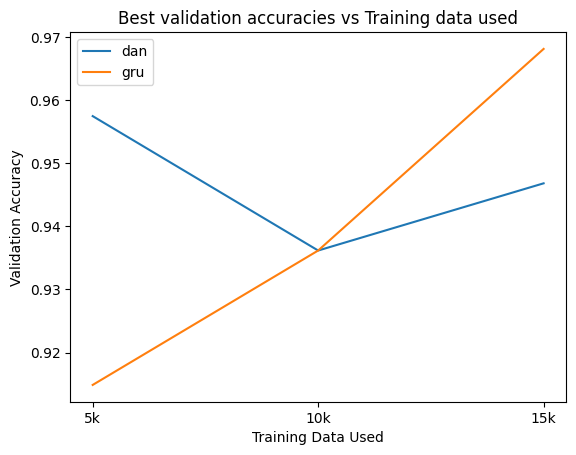

<Figure size 640x480 with 0 Axes>

In [ ]:
def analyze_perf_vs_data_size():
    seq2vec_choices = ["dan", "gru"]
    datasets = {
        "5k": imdb_sentiment_train_5k_path,
        "10k": imdb_sentiment_train_10k_path,
        "15k": imdb_sentiment_train_15k_path,
    }
    validation_accuracies = {"dan": [], "gru": []}
    validation_accuracies["dan"] = [0] * len(datasets)
    validation_accuracies["gru"] = [0] * len(datasets)
    train_args["model_name"] = "main"
    train_args["num_epochs"] = 8
    train_args["embedding_dim"] = 50
    train_args["num_layers"] = 4
    train_args["batch_size"] = 32
    train_args["pretrained_embedding_file"] = pretrained_embedding_path
    for seq2vec_choice in seq2vec_choices:
        for ds in datasets:
            serialization_dir = os.path.join(
                "serialization_dirs", f"main_{seq2vec_choice}_{ds}_with_emb"
            )
            metrics_path = os.path.join(serialization_dir, "metrics.json")
            if not os.path.exists(metrics_path):
                train_args["train_data_file_path"] = datasets[ds]
                train_args["validation_data_file_path"] = imdb_sentiment_dev_path
                train_args["suffix_name"] = f"_{seq2vec_choice}_{ds}_with_emb"
                train_args["seq2vec_choice"] = seq2vec_choice
                train_args["base_model_dir"] = serialization_dir
                print(f"Training the model with arguments:\n{train_args}")
                train_wrapper(train_args)
                predict_args["load_serialization_dir"] = serialization_dir
                predict_args["data_file_path"] = imdb_sentiment_test_path
                predict_args[
                    "predictions_file"
                ] = f"main_{seq2vec_choice}_{ds}_predictions.txt"
                print(f"Generating test predictions with arguments:\n{predict_args}")
                test_wrapper(predict_args)
                print(
                    f"Evaluating model using the following arguments:\n{predict_args}"
                )
                evaluate_args["gold_data_path"] = imdb_sentiment_test_path
                evaluate_args[
                    "prediction_data_path"
                ] = f"main_{seq2vec_choice}_{ds}_predictions.txt"
                evaluate_wrapper(evaluate_args)
            else:
                with open(metrics_path) as file:
                    metrics = json.load(file)
                    validation_accuracy = metrics.get(
                        "best_epoch_validation_accuracy", 0
                    )  # Default value 0
                    index = list(datasets.keys()).index(ds)
                    validation_accuracies[seq2vec_choice][index] = validation_accuracy
                validation_accuracies[seq2vec_choice][
                    list(datasets.keys()).index(ds)
                ] = metrics["best_epoch_validation_accuracy"]

    print(datasets, validation_accuracies)
    for seq2vec_choice in seq2vec_choices:
        plt.plot(
            list(datasets.keys()),
            validation_accuracies[seq2vec_choice],
            label=seq2vec_choice,
        )
    plt.xlabel("Training Data Used")
    plt.ylabel("Validation Accuracy")
    plt.title("Best validation accuracies vs Training data used")
    plt.legend()
    plt.savefig(os.path.join("plots", "performance_against_data_size_with_glove.png"))
    plt.show()
    plt.clf()

!rm -rf plots
!mkdir plots
analyze_perf_vs_data_size()

We expect the performance of the models to increase with the size of the dataset. This is because the models will have more data to learn from and will be able to generalize better. The rate of increase may not be linear due to possible issues like diminishing returns or overfitting, depending on the architecture. Increasing the size of the dataset will also increase the training time and consume more resources.

We can see that the performance of both models either hovers around the same accuracy or increases with the size of the dataset. While the DAN model performs slightly better than GRU at 5k, it performs slightly lower at 15k; the GRU model shows a more substantial increase in performance as the size of the dataset increases. This is mostly in line with our expectations, as the GRU model is more complex and has more parameters to learn, so it will take more data to train it well. The DAN model is simpler and has fewer parameters, so it can be trained with less data.


#### Training Time


In this section we train DAN and GRU for 50 epochs and observe the results. As the number of epochs increases, the models will be exposed to the training data for longer, and will have more opportunities to adjust their weights to fit the data. This will increase the training time, but will also increase the performance of the models. This behavior depends on several factors, including overfitting, convergence, and model complexity. Due to aforementioned reasons, we expect DAN will converge faster and will not overfit as easily, but GRU will take longer to train and will be more likely to overfit.


##### DAN


In [ ]:
train_args = DictX({})
predict_args = DictX({})
evaluate_args = DictX({})

# Arguments for training
train_args["model_name"] = "main"
train_args["train_data_file_path"] = imdb_sentiment_train_15k_path
train_args["validation_data_file_path"] = imdb_sentiment_dev_path
train_args["suffix_name"] = "_dan_15k_with_emb_50_epoch"
train_args["batch_size"] = 32
train_args["num_epochs"] = 50
train_args["seq2vec_choice"] = "dan"
train_args["embedding_dim"] = 50
train_args["num_layers"] = 4
train_args["pretrained_embedding_file"] = pretrained_embedding_path


# Arguments for probing
train_args["base-model-dir"] = ""
train_args["layer_num"] = ""

# Arguments for testing
predict_args[
    "load_serialization_dir"
] = "serialization_dirs/main_dan_15k_with_emb_50_epoch"
predict_args["data_file_path"] = imdb_sentiment_test_path
predict_args["predictions_file"] = "dan_predictions_15k_50_epoch.txt"
predict_args["batch_size"] = 32

# Arguments for evaluating
evaluate_args["gold_data_path"] = imdb_sentiment_test_path
evaluate_args["prediction_data_path"] = "dan_predictions.txt"

print(f"Training the model with arguments:\n{train_args}")
train_wrapper(train_args)
print(f"Generating test predictions with arguments:\n{predict_args}")
test_wrapper(predict_args)
print(f"Evaluating model using the following arguments:\n{predict_args}")
evaluate_wrapper(evaluate_args)

Training the model with arguments:
<DictX {'model_name': 'main', 'train_data_file_path': 'data/imdb_sentiment_train_15k.jsonl', 'validation_data_file_path': 'data/imdb_sentiment_dev.jsonl', 'suffix_name': '_dan_15k_with_emb_50_epoch', 'batch_size': 32, 'num_epochs': 50, 'seq2vec_choice': 'dan', 'embedding_dim': 50, 'num_layers': 4, 'pretrained_embedding_file': 'data/glove.6B.50d.txt', 'base-model-dir': '', 'layer_num': ''}>
Device: cuda:0
Reading training instances.


100%|██████████| 15000/15000 [00:05<00:00, 2865.14it/s]


Reading validation instances.


100%|██████████| 3000/3000 [00:00<00:00, 3749.13it/s]



Building Vocabulary.

Reading pretrained embedding file.


400000it [00:00, 521598.51it/s]



Generating Training batches:


100%|██████████| 469/469 [00:00<00:00, 3122.54it/s]


Generating Validation batches:


100%|██████████| 94/94 [00:00<00:00, 2704.85it/s]



Epoch 1


Average validation loss: 0.34 Accuracy: 0.86 : 100%|██████████| 94/94 [00:00<00:00, 1014.83it/s]


Model with best validation accuracy so far: 0.86. Saving the model.

Epoch 2


Average validation loss: 0.27 Accuracy: 0.89 : 100%|██████████| 94/94 [00:00<00:00, 708.00it/s]


Model with best validation accuracy so far: 0.89. Saving the model.

Epoch 3


Average validation loss: 0.26 Accuracy: 0.89 : 100%|██████████| 94/94 [00:00<00:00, 917.70it/s]



Epoch 4


Average validation loss: 0.25 Accuracy: 0.89 : 100%|██████████| 94/94 [00:00<00:00, 994.56it/s]



Epoch 5


Average validation loss: 0.28 Accuracy: 0.91 : 100%|██████████| 94/94 [00:00<00:00, 965.19it/s]


Model with best validation accuracy so far: 0.91. Saving the model.

Epoch 6


Average validation loss: 0.21 Accuracy: 0.93 : 100%|██████████| 94/94 [00:00<00:00, 954.24it/s]


Model with best validation accuracy so far: 0.93. Saving the model.

Epoch 7


Average validation loss: 0.20 Accuracy: 0.94 : 100%|██████████| 94/94 [00:00<00:00, 1021.17it/s]


Model with best validation accuracy so far: 0.94. Saving the model.

Epoch 8


Average validation loss: 0.22 Accuracy: 0.96 : 100%|██████████| 94/94 [00:00<00:00, 950.04it/s]


Model with best validation accuracy so far: 0.96. Saving the model.

Epoch 9


Average validation loss: 0.20 Accuracy: 0.95 : 100%|██████████| 94/94 [00:00<00:00, 734.50it/s]



Epoch 10


Average validation loss: 0.21 Accuracy: 0.94 : 100%|██████████| 94/94 [00:00<00:00, 727.92it/s]



Epoch 11


Average validation loss: 0.21 Accuracy: 0.95 : 100%|██████████| 94/94 [00:00<00:00, 920.30it/s]



Epoch 12


Average validation loss: 0.25 Accuracy: 0.93 : 100%|██████████| 94/94 [00:00<00:00, 1003.01it/s]



Epoch 13


Average validation loss: 0.24 Accuracy: 0.94 : 100%|██████████| 94/94 [00:00<00:00, 954.99it/s]



Epoch 14


Average validation loss: 0.23 Accuracy: 0.95 : 100%|██████████| 94/94 [00:00<00:00, 941.69it/s]



Epoch 15


Average validation loss: 0.26 Accuracy: 0.94 : 100%|██████████| 94/94 [00:00<00:00, 865.87it/s]



Epoch 16


Average validation loss: 0.31 Accuracy: 0.91 : 100%|██████████| 94/94 [00:00<00:00, 942.90it/s]



Epoch 17


Average validation loss: 0.26 Accuracy: 0.93 : 100%|██████████| 94/94 [00:00<00:00, 770.88it/s]



Epoch 18


Average validation loss: 0.31 Accuracy: 0.94 : 100%|██████████| 94/94 [00:00<00:00, 775.25it/s]



Epoch 19


Average validation loss: 0.26 Accuracy: 0.94 : 100%|██████████| 94/94 [00:00<00:00, 980.01it/s]



Epoch 20


Average validation loss: 0.25 Accuracy: 0.96 : 100%|██████████| 94/94 [00:00<00:00, 953.76it/s]



Epoch 21


Average validation loss: 0.26 Accuracy: 0.95 : 100%|██████████| 94/94 [00:00<00:00, 1011.34it/s]



Epoch 22


Average validation loss: 0.29 Accuracy: 0.94 : 100%|██████████| 94/94 [00:00<00:00, 982.82it/s]



Epoch 23


Average validation loss: 0.29 Accuracy: 0.96 : 100%|██████████| 94/94 [00:00<00:00, 983.45it/s]



Epoch 24


Average validation loss: 0.29 Accuracy: 0.97 : 100%|██████████| 94/94 [00:00<00:00, 965.73it/s]


Model with best validation accuracy so far: 0.97. Saving the model.

Epoch 25


Average validation loss: 0.29 Accuracy: 0.97 : 100%|██████████| 94/94 [00:00<00:00, 666.57it/s]



Epoch 26


Average validation loss: 0.28 Accuracy: 0.97 : 100%|██████████| 94/94 [00:00<00:00, 780.84it/s]



Epoch 27


Average validation loss: 0.31 Accuracy: 0.96 : 100%|██████████| 94/94 [00:00<00:00, 1004.33it/s]



Epoch 28


Average validation loss: 0.30 Accuracy: 0.97 : 100%|██████████| 94/94 [00:00<00:00, 942.30it/s]



Epoch 29


Average validation loss: 0.33 Accuracy: 0.95 : 100%|██████████| 94/94 [00:00<00:00, 969.95it/s]



Epoch 30


Average validation loss: 0.34 Accuracy: 0.93 : 100%|██████████| 94/94 [00:00<00:00, 984.92it/s]



Epoch 31


Average validation loss: 0.36 Accuracy: 0.93 : 100%|██████████| 94/94 [00:00<00:00, 978.98it/s]



Epoch 32


Average validation loss: 0.31 Accuracy: 0.96 : 100%|██████████| 94/94 [00:00<00:00, 942.30it/s]



Epoch 33


Average validation loss: 0.36 Accuracy: 0.95 : 100%|██████████| 94/94 [00:00<00:00, 696.70it/s]



Epoch 34


Average validation loss: 0.36 Accuracy: 0.96 : 100%|██████████| 94/94 [00:00<00:00, 725.31it/s]



Epoch 35


Average validation loss: 0.32 Accuracy: 0.96 : 100%|██████████| 94/94 [00:00<00:00, 1002.83it/s]



Epoch 36


Average validation loss: 0.38 Accuracy: 0.95 : 100%|██████████| 94/94 [00:00<00:00, 939.51it/s]



Epoch 37


Average validation loss: 0.43 Accuracy: 0.95 : 100%|██████████| 94/94 [00:00<00:00, 987.61it/s]



Epoch 38


Average validation loss: 0.42 Accuracy: 0.95 : 100%|██████████| 94/94 [00:00<00:00, 818.83it/s]



Epoch 39


Average validation loss: 0.40 Accuracy: 0.95 : 100%|██████████| 94/94 [00:00<00:00, 1013.29it/s]



Epoch 40


Average validation loss: 0.46 Accuracy: 0.97 : 100%|██████████| 94/94 [00:00<00:00, 994.39it/s]



Epoch 41


Average validation loss: 0.40 Accuracy: 0.96 : 100%|██████████| 94/94 [00:00<00:00, 992.17it/s]



Epoch 42


Average validation loss: 0.35 Accuracy: 0.97 : 100%|██████████| 94/94 [00:00<00:00, 731.14it/s]



Epoch 43


Average validation loss: 0.46 Accuracy: 0.91 : 100%|██████████| 94/94 [00:00<00:00, 978.81it/s]



Epoch 44


Average validation loss: 0.39 Accuracy: 0.97 : 100%|██████████| 94/94 [00:00<00:00, 1005.79it/s]



Epoch 45


Average validation loss: 0.42 Accuracy: 0.95 : 100%|██████████| 94/94 [00:00<00:00, 998.04it/s]



Epoch 46


Average validation loss: 0.37 Accuracy: 0.96 : 100%|██████████| 94/94 [00:00<00:00, 1005.92it/s]



Epoch 47


Average validation loss: 0.41 Accuracy: 0.96 : 100%|██████████| 94/94 [00:00<00:00, 877.82it/s]



Epoch 48


Average validation loss: 0.39 Accuracy: 0.96 : 100%|██████████| 94/94 [00:00<00:00, 972.57it/s]



Epoch 49


Average validation loss: 0.49 Accuracy: 0.94 : 100%|██████████| 94/94 [00:00<00:00, 1006.10it/s]



Epoch 50


Average validation loss: 0.46 Accuracy: 0.95 : 100%|██████████| 94/94 [00:00<00:00, 631.38it/s]


Best epoch validation accuracy: 0.9681, validation loss: 0.2871

Final model stored in serialization directory: serialization_dirs/main_dan_15k_with_emb_50_epoch
Generating test predictions with arguments:
<DictX {'load_serialization_dir': 'serialization_dirs/main_dan_15k_with_emb_50_epoch', 'data_file_path': 'data/imdb_sentiment_test.jsonl', 'predictions_file': 'dan_predictions_15k_50_epoch.txt', 'batch_size': 32}>


100%|██████████| 94/94 [00:00<00:00, 2636.30it/s]


Making predictions


100%|██████████| 94/94 [00:00<00:00, 1158.23it/s]


Saving predictions to filepath: dan_predictions_15k_50_epoch.txt
Evaluating model using the following arguments:
<DictX {'load_serialization_dir': 'serialization_dirs/main_dan_15k_with_emb_50_epoch', 'data_file_path': 'data/imdb_sentiment_test.jsonl', 'predictions_file': 'dan_predictions_15k_50_epoch.txt', 'batch_size': 32}>
Accuracy: 0.84


##### GRU


In [ ]:
train_args = DictX({})
predict_args = DictX({})
evaluate_args = DictX({})

# Arguments for training
train_args["model_name"] = "main"
train_args["train_data_file_path"] = imdb_sentiment_train_15k_path
train_args["validation_data_file_path"] = imdb_sentiment_dev_path
train_args["suffix_name"] = "_gru_15k_with_emb_50_epoch"
train_args["batch_size"] = 32
train_args["num_epochs"] = 50
train_args["seq2vec_choice"] = "gru"
train_args["embedding_dim"] = 50
train_args["num_layers"] = 4
train_args["pretrained_embedding_file"] = pretrained_embedding_path


# Arguments for probing
train_args["base-model-dir"] = ""
train_args["layer_num"] = ""

# Arguments for testing
predict_args[
    "load_serialization_dir"
] = "serialization_dirs/main_gru_15k_with_emb_50_epoch"
predict_args["data_file_path"] = imdb_sentiment_test_path
predict_args["predictions_file"] = "gru_predictions_15k_50_epoch.txt"
predict_args["batch_size"] = 32

# Arguments for evaluating
evaluate_args["gold_data_path"] = imdb_sentiment_test_path
evaluate_args["prediction_data_path"] = "dan_predictions.txt"

print(f"Training the model with arguments:\n{train_args}")
train_wrapper(train_args)
print(f"Generating test predictions with arguments:\n{predict_args}")
test_wrapper(predict_args)
print(f"Evaluating model using the following arguments:\n{predict_args}")
evaluate_wrapper(evaluate_args)

Training the model with arguments:
<DictX {'model_name': 'main', 'train_data_file_path': 'data/imdb_sentiment_train_15k.jsonl', 'validation_data_file_path': 'data/imdb_sentiment_dev.jsonl', 'suffix_name': '_gru_15k_with_emb_50_epoch', 'batch_size': 32, 'num_epochs': 50, 'seq2vec_choice': 'gru', 'embedding_dim': 50, 'num_layers': 4, 'pretrained_embedding_file': 'data/glove.6B.50d.txt', 'base-model-dir': '', 'layer_num': ''}>
Device: cuda:0
Reading training instances.


100%|██████████| 15000/15000 [00:03<00:00, 3852.16it/s]


Reading validation instances.


100%|██████████| 3000/3000 [00:00<00:00, 3710.62it/s]



Building Vocabulary.

Reading pretrained embedding file.


400000it [00:00, 534260.30it/s]



Generating Training batches:


100%|██████████| 469/469 [00:00<00:00, 2676.49it/s]


Generating Validation batches:


100%|██████████| 94/94 [00:00<00:00, 2635.81it/s]



Epoch 1


Average validation loss: 0.30 Accuracy: 0.88 : 100%|██████████| 94/94 [00:01<00:00, 93.54it/s]


Model with best validation accuracy so far: 0.88. Saving the model.

Epoch 2


Average validation loss: 0.25 Accuracy: 0.89 : 100%|██████████| 94/94 [00:01<00:00, 78.93it/s]


Model with best validation accuracy so far: 0.89. Saving the model.

Epoch 3


Average validation loss: 0.19 Accuracy: 0.93 : 100%|██████████| 94/94 [00:00<00:00, 103.64it/s]


Model with best validation accuracy so far: 0.93. Saving the model.

Epoch 4


Average validation loss: 0.20 Accuracy: 0.95 : 100%|██████████| 94/94 [00:00<00:00, 105.84it/s]


Model with best validation accuracy so far: 0.95. Saving the model.

Epoch 5


Average validation loss: 0.20 Accuracy: 0.96 : 100%|██████████| 94/94 [00:00<00:00, 107.69it/s]


Model with best validation accuracy so far: 0.96. Saving the model.

Epoch 6


Average validation loss: 0.22 Accuracy: 0.97 : 100%|██████████| 94/94 [00:00<00:00, 106.36it/s]


Model with best validation accuracy so far: 0.97. Saving the model.

Epoch 7


Average validation loss: 0.22 Accuracy: 0.96 : 100%|██████████| 94/94 [00:00<00:00, 108.08it/s]



Epoch 8


Average validation loss: 0.23 Accuracy: 0.96 : 100%|██████████| 94/94 [00:00<00:00, 105.60it/s]



Epoch 9


Average validation loss: 0.23 Accuracy: 0.96 : 100%|██████████| 94/94 [00:00<00:00, 104.46it/s]



Epoch 10


Average validation loss: 0.28 Accuracy: 0.97 : 100%|██████████| 94/94 [00:00<00:00, 98.25it/s]



Epoch 11


Average validation loss: 0.29 Accuracy: 0.96 : 100%|██████████| 94/94 [00:01<00:00, 71.62it/s]



Epoch 12


Average validation loss: 0.24 Accuracy: 0.96 : 100%|██████████| 94/94 [00:01<00:00, 84.08it/s]



Epoch 13


Average validation loss: 0.25 Accuracy: 0.96 : 100%|██████████| 94/94 [00:00<00:00, 105.01it/s]



Epoch 14


Average validation loss: 0.27 Accuracy: 0.96 : 100%|██████████| 94/94 [00:00<00:00, 104.84it/s]



Epoch 15


Average validation loss: 0.30 Accuracy: 0.97 : 100%|██████████| 94/94 [00:00<00:00, 107.56it/s]



Epoch 16


Average validation loss: 0.33 Accuracy: 0.98 : 100%|██████████| 94/94 [00:00<00:00, 107.53it/s]


Model with best validation accuracy so far: 0.98. Saving the model.

Epoch 17


Average validation loss: 0.29 Accuracy: 0.97 : 100%|██████████| 94/94 [00:00<00:00, 103.95it/s]



Epoch 18


Average validation loss: 0.34 Accuracy: 0.97 : 100%|██████████| 94/94 [00:00<00:00, 105.65it/s]



Epoch 19


Average validation loss: 0.31 Accuracy: 0.96 : 100%|██████████| 94/94 [00:00<00:00, 106.65it/s]



Epoch 20


Average validation loss: 0.29 Accuracy: 0.97 : 100%|██████████| 94/94 [00:00<00:00, 105.69it/s]



Epoch 21


Average validation loss: 0.31 Accuracy: 0.97 : 100%|██████████| 94/94 [00:01<00:00, 72.01it/s]



Epoch 22


Average validation loss: 0.26 Accuracy: 0.96 : 100%|██████████| 94/94 [00:01<00:00, 73.85it/s]



Epoch 23


Average validation loss: 0.30 Accuracy: 0.96 : 100%|██████████| 94/94 [00:00<00:00, 106.81it/s]



Epoch 24


Average validation loss: 0.31 Accuracy: 0.96 : 100%|██████████| 94/94 [00:00<00:00, 106.20it/s]



Epoch 25


Average validation loss: 0.31 Accuracy: 0.97 : 100%|██████████| 94/94 [00:00<00:00, 103.69it/s]



Epoch 26


Average validation loss: 0.36 Accuracy: 0.96 : 100%|██████████| 94/94 [00:00<00:00, 105.83it/s]



Epoch 27


Average validation loss: 0.31 Accuracy: 0.96 : 100%|██████████| 94/94 [00:00<00:00, 105.78it/s]



Epoch 28


Average validation loss: 0.35 Accuracy: 0.96 : 100%|██████████| 94/94 [00:00<00:00, 107.45it/s]



Epoch 29


Average validation loss: 0.34 Accuracy: 0.96 : 100%|██████████| 94/94 [00:00<00:00, 103.38it/s]



Epoch 30


Average validation loss: 0.33 Accuracy: 0.95 : 100%|██████████| 94/94 [00:00<00:00, 104.66it/s]



Epoch 31


Average validation loss: 0.35 Accuracy: 0.96 : 100%|██████████| 94/94 [00:01<00:00, 74.11it/s]



Epoch 32


Average validation loss: 0.36 Accuracy: 0.96 : 100%|██████████| 94/94 [00:01<00:00, 73.32it/s]



Epoch 33


Average validation loss: 0.36 Accuracy: 0.96 : 100%|██████████| 94/94 [00:00<00:00, 104.09it/s]



Epoch 34


Average validation loss: 0.36 Accuracy: 0.96 : 100%|██████████| 94/94 [00:00<00:00, 104.23it/s]



Epoch 35


Average validation loss: 0.35 Accuracy: 0.95 : 100%|██████████| 94/94 [00:00<00:00, 105.41it/s]



Epoch 36


Average validation loss: 0.35 Accuracy: 0.97 : 100%|██████████| 94/94 [00:00<00:00, 105.14it/s]



Epoch 37


Average validation loss: 0.37 Accuracy: 0.97 : 100%|██████████| 94/94 [00:00<00:00, 104.65it/s]



Epoch 38


Average validation loss: 0.37 Accuracy: 0.97 : 100%|██████████| 94/94 [00:00<00:00, 105.88it/s]



Epoch 39


Average validation loss: 0.35 Accuracy: 0.98 : 100%|██████████| 94/94 [00:00<00:00, 102.95it/s]



Epoch 40


Average validation loss: 0.36 Accuracy: 0.98 : 100%|██████████| 94/94 [00:00<00:00, 94.33it/s]



Epoch 41


Average validation loss: 0.39 Accuracy: 0.97 : 100%|██████████| 94/94 [00:01<00:00, 70.57it/s]



Epoch 42


Average validation loss: 0.38 Accuracy: 0.97 : 100%|██████████| 94/94 [00:01<00:00, 84.45it/s]



Epoch 43


Average validation loss: 0.37 Accuracy: 0.97 : 100%|██████████| 94/94 [00:00<00:00, 108.06it/s]



Epoch 44


Average validation loss: 0.38 Accuracy: 0.96 : 100%|██████████| 94/94 [00:00<00:00, 107.16it/s]



Epoch 45


Average validation loss: 0.39 Accuracy: 0.98 : 100%|██████████| 94/94 [00:00<00:00, 104.70it/s]



Epoch 46


Average validation loss: 0.33 Accuracy: 0.96 : 100%|██████████| 94/94 [00:00<00:00, 104.00it/s]



Epoch 47


Average validation loss: 0.37 Accuracy: 0.97 : 100%|██████████| 94/94 [00:00<00:00, 101.66it/s]



Epoch 48


Average validation loss: 0.38 Accuracy: 0.96 : 100%|██████████| 94/94 [00:00<00:00, 104.55it/s]



Epoch 49


Average validation loss: 0.39 Accuracy: 0.97 : 100%|██████████| 94/94 [00:00<00:00, 104.26it/s]



Epoch 50


Average validation loss: 0.40 Accuracy: 0.97 : 100%|██████████| 94/94 [00:01<00:00, 71.56it/s]


Best epoch validation accuracy: 0.9787, validation loss: 0.3273

Final model stored in serialization directory: serialization_dirs/main_gru_15k_with_emb_50_epoch
Generating test predictions with arguments:
<DictX {'load_serialization_dir': 'serialization_dirs/main_gru_15k_with_emb_50_epoch', 'data_file_path': 'data/imdb_sentiment_test.jsonl', 'predictions_file': 'gru_predictions_15k_50_epoch.txt', 'batch_size': 32}>


100%|██████████| 94/94 [00:00<00:00, 2650.59it/s]


Making predictions


100%|██████████| 94/94 [00:00<00:00, 106.06it/s]


Saving predictions to filepath: gru_predictions_15k_50_epoch.txt
Evaluating model using the following arguments:
<DictX {'load_serialization_dir': 'serialization_dirs/main_gru_15k_with_emb_50_epoch', 'data_file_path': 'data/imdb_sentiment_test.jsonl', 'predictions_file': 'gru_predictions_15k_50_epoch.txt', 'batch_size': 32}>
Accuracy: 0.84


##### Analysis


In [ ]:
%load_ext tensorboard
%tensorboard --logdir "serialization_dirs"

Output hidden; open in https://colab.research.google.com to view.

![Tensorboard](plots/tensorboard.png)

The results show that both DAN and GRU models improve their performance as the number of epochs increases. However, the improvement is not as significant in the later epochs as it is in the earlier epochs. This aligns with the expectation that the performance of the models might plateau or even degrade after a certain number of epochs due to overfitting or convergence.

We observe that the DAN model converges faster than the GRU model. The DAN model has a lower loss and a higher accuracy than the GRU model. This is in line with our expectations. Should the learning rate be increased, the models will take larger steps and will converge faster. However, they will also be more likely to overshoot the minimum and will not converge to the optimal solution. If the learning rate is decreased, the models will take smaller steps and will converge more slowly, with more precision; however, the risk of getting stuck in a local minimum is higher.

GRU models seem to perform better in cases where the order of words or the context of the sentence is crucial to understanding the meaning. DAN models, due to their averaging nature, might struggle more with ambiguous cases, such as involving polysemy. DAN, unlike GRU, might correctly predict an answer based on the overall meaning of a sentence because they are better at capturing sentence-level features and understanding the overall meaning of sentences, rather than relationships between individual words and their ordering like GRU.


### Probing: Layer Depth vs Information Retained


In this task, we are interested in what each layer of our models (both DAN and GRU) are capturing with respect to their ability to predict sentiment. We will first take output of first hidden layer, then second, and so on. The output of these layers is then fed to a linear classifier which makes the prediction. Thus we get 4 models for 4 layers.

We expect the model with the highest number of layers to perform the best, as it will have the most information to work with. However, the model with the highest number of layers will also be the most complex and will be more likely to overfit or suffer from vanishing gradients. For the DAN model, which uses an average of word embeddings as input and then applies multiple feedforward layers, we expect that the deeper layers will capture more meaningful and abstract representations of the input. We expect the same for the GRU model, which uses a sequence of word embeddings as input and then applies multiple recurrent layers.


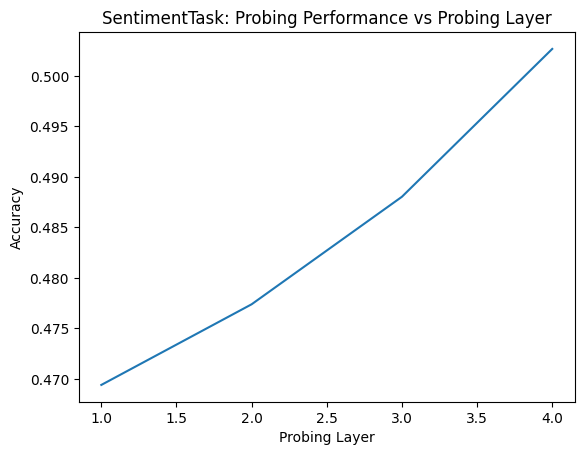

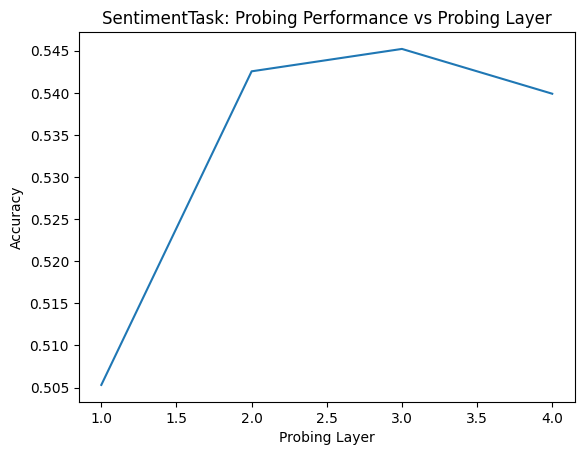

<Figure size 640x480 with 0 Axes>

In [ ]:
def probing_layer_info():
    probing_accuracies = {"dan": [], "gru": []}
    choices = {"dan": range(1, 4 + 1), "gru": range(1, 4 + 1)}
    datasets = {
        "5k": imdb_sentiment_train_5k_path,
        "10k": imdb_sentiment_train_10k_path,
        "15k": imdb_sentiment_train_15k_path,
    }
    train_args["model_name"] = "main"
    train_args["num_epochs"] = 8
    train_args["embedding_dim"] = 50
    train_args["num_layers"] = 4
    train_args["batch_size"] = 32
    train_args["pretrained_embedding_file"] = pretrained_embedding_path
    for seq2vec_choice, layers in choices.items():
        serialization_dir = os.path.join(
            "serialization_dirs", f"main_{seq2vec_choice}_5k_with_emb"
        )
        metrics_path = os.path.join(serialization_dir, "metrics.json")
        if not os.path.exists(metrics_path):
            train_args["train_data_file_path"] = datasets["5k"]
            train_args["validation_data_file_path"] = imdb_sentiment_dev_path
            train_args["suffix_name"] = f"_{seq2vec_choice}_5k_with_emb"
            train_args["seq2vec_choice"] = seq2vec_choice
            train_args["base_model_dir"] = serialization_dir
            print(f"Training the model with arguments:\n{train_args}")
            train_wrapper(train_args)
            predict_args["load_serialization_dir"] = serialization_dir
            predict_args["data_file_path"] = imdb_sentiment_test_path
            predict_args[
                "predictions_file"
            ] = f"main_{seq2vec_choice}_5k_predictions.txt"
            print(f"Generating test predictions with arguments:\n{predict_args}")
            test_wrapper(predict_args)
            print(f"Evaluating model using the following arguments:\n{predict_args}")
            evaluate_args["gold_data_path"] = imdb_sentiment_test_path
            evaluate_args[
                "prediction_data_path"
            ] = f"main_{seq2vec_choice}_5k_predictions.txt"
            evaluate_wrapper(evaluate_args)

        for layer in layers:
            serialization_dir = os.path.join(
                "serialization_dirs",
                f"probing_sentiment_{seq2vec_choice}_with_emb_on_5k_at_layer_{layer}",
            )
            model_files_present = all(
                [
                    os.path.exists(os.path.join(serialization_dir, file_name))
                    for file_name in ["model.pkg", "config.json", "vocab.txt"]
                ]
            )
            predictions_file = (
                f"serialization_dirs/probing_sentiment_{seq2vec_choice}_with_emb_on_5k_at_layer_{layer}/"
                f"predictions_imdb_sentiment_5k_test.txt"
            )
            predictions_present = os.path.exists(predictions_file)

            if not model_files_present:
                train_args["model_name"] = "probing"
                train_args["train_data_file_path"] = imdb_sentiment_train_5k_path
                train_args["validation_data_file_path"] = imdb_sentiment_dev_path
                train_args[
                    "base_model_dir"
                ] = f"serialization_dirs/main_{seq2vec_choice}_5k_with_emb"
                train_args[
                    "suffix_name"
                ] = f"_sentiment_{seq2vec_choice}_with_emb_on_5k_at_layer_{layer}"
                train_args["seq2vec_choice"] = seq2vec_choice
                train_args["layer_num"] = layer
                print(f"Training the model with arguments:\n{train_args}")
                train_wrapper(train_args)

            if not predictions_present:
                predict_args[
                    "load_serialization_dir"
                ] = f"serialization_dirs/probing_sentiment_{seq2vec_choice}_with_emb_on_5k_at_layer_{layer}"
                predict_args["data_file_path"] = imdb_sentiment_test_path
                predict_args[
                    "base_model_dir"
                ] = f"serialization_dirs/main_{seq2vec_choice}_5k_with_emb"
                predict_args[
                    "predictions_file"
                ] = f"serialization_dirs/probing_sentiment_{seq2vec_choice}_with_emb_on_5k_at_layer_{layer}/predictions_imdb_sentiment_5k_test.txt"
                print(f"Generating test predictions with arguments:\n{predict_args}")
                test_wrapper(predict_args)

            accuracy = evaluate("data/imdb_sentiment_test.jsonl", predictions_file)
            probing_accuracies[seq2vec_choice].append(accuracy)

    for seq2vec_choice, layer_range in choices.items():
        plt.plot(layer_range, probing_accuracies[seq2vec_choice])
        plt.xlabel("Probing Layer")
        plt.ylabel("Accuracy")
        title = "SentimentTask: Probing Performance vs Probing Layer"
        plt.title(title)
        plt.savefig(
            os.path.join(
                "plots", f"probing_performance_on_sentiment_task_{seq2vec_choice}.png"
            )
        )
        plt.show()
        plt.clf()


probing_layer_info()

The results for the DAN model show that the performance of the probing layers increases slightly as the number of layers increases. This is in line with our expectations, as the deeper layers will have more information to work with and will be able to capture more abstract representations of the input.

The results for the GRU model show that the performance of the probing layers also increases as the number of layers increases; however, the performance drops slightly after the 3rd layer. This is not in line with our expectations, as we expected the performance to increase as the number of layers increases. This might be due to the fact that the GRU model is more complex and has more parameters, so it is more likely to overfit or suffer from vanishing gradients.

Overall, the results generally match our expectations that the deeper layers are more likely to perform better. The improvements in performance are not as significant as we expected, and this might be due to the fact that the models are not optimally tuned.


### Bigram Order


In this task, we are looking at a direct comparison of DAN vs GRU in their ability to predict order of words. Specifically, the task is to classify whether a bigram is in correct order or reversed. For example, `New York` is in correct order and `York New` is reversed.

We expect the GRU model to perform better than the DAN model on this task, as the GRU model is able to capture long-term dependencies in the data and model relationships between words in their specific order. The GRU model is better suited for classifying whether a bigram is in the correct order or reversed because its hidden states are able to capture the order of the words in the sentence. The DAN model might have difficulty distinguishing between correct and reversed bigrams since it primarily focuses on the semantic content of the input tokens without considering their order.


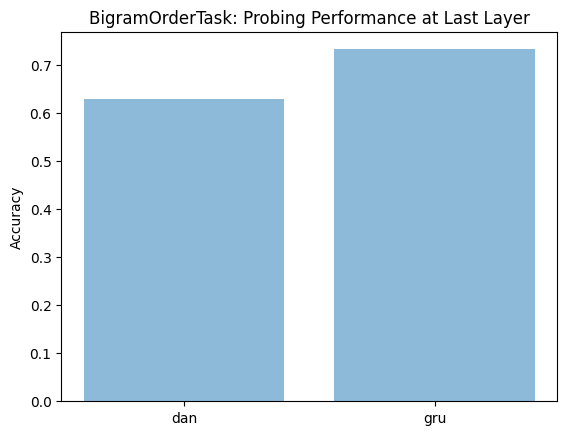

In [ ]:
def bigram_order():
    seq2vec_name_to_last_layer = {"dan": 4, "gru": 4}
    probing_accuracies = {}

    for seq2vec_name, layer in seq2vec_name_to_last_layer.items():
        # Check if Base Models have been trained first.
        serialization_dir = os.path.join(
            "serialization_dirs", f"main_{seq2vec_name}_5k_with_emb"
        )
        model_files_present = all(
            [
                os.path.exists(os.path.join(serialization_dir, file_name))
                for file_name in ["model.pkg", "config.json", "vocab.txt"]
            ]
        )
        if not model_files_present:
            train_args["model_name"] = "main"
            train_args["num_epochs"] = 8
            train_args["embedding_dim"] = 50
            train_args["num_layers"] = 4
            train_args["batch_size"] = 32
            train_args["pretrained_embedding_file"] = pretrained_embedding_path
            train_args["train_data_file_path"] = imdb_sentiment_train_5k_path
            train_args["validation_data_file_path"] = imdb_sentiment_dev_path
            train_args["suffix_name"] = f"_{seq2vec_name}_5k_with_emb"
            train_args["seq2vec_choice"] = seq2vec_name
            train_args["base_model_dir"] = serialization_dir
            print(f"Training the model with arguments:\n{train_args}")
            train_wrapper(train_args)
            predict_args["load_serialization_dir"] = serialization_dir
            predict_args["data_file_path"] = imdb_sentiment_test_path
            predict_args["predictions_file"] = f"main_{seq2vec_name}_5k_predictions.txt"
            print(f"Generating test predictions with arguments:\n{predict_args}")
            test_wrapper(predict_args)
            print(f"Evaluating model using the following arguments:\n{predict_args}")
            evaluate_args["gold_data_path"] = imdb_sentiment_test_path
            evaluate_args[
                "prediction_data_path"
            ] = f"main_{seq2vec_name}_5k_predictions.txt"
            evaluate_wrapper(evaluate_args)

        serialization_dir = os.path.join(
            "serialization_dirs",
            f"probing_bigram_order_{seq2vec_name}_with_emb_on_5k_at_layer_{layer}",
        )
        model_files_present = all(
            [
                os.path.exists(os.path.join(serialization_dir, file_name))
                for file_name in ["model.pkg", "config.json", "vocab.txt"]
            ]
        )
        predictions_file = (
            f"serialization_dirs/probing_bigram_order_{seq2vec_name}_with_emb_on_5k_at_layer_{layer}/"
            f"predictions_bigram_order_test.txt"
        )

        if not model_files_present:
            train_args["model_name"] = "probing"
            train_args["train_data_file_path"] = f"data/bigram_order_train.jsonl"
            train_args["validation_data_file_path"] = f"data/bigram_order_dev.jsonl"
            train_args[
                "base_model_dir"
            ] = f"serialization_dirs/main_{seq2vec_name}_5k_with_emb"
            train_args[
                "suffix_name"
            ] = f"_bigram_order_{seq2vec_name}_with_emb_on_5k_at_layer_{layer}"
            train_args["seq2vec_choice"] = seq2vec_name
            train_args["layer_num"] = layer
            train_args["num_epochs"] = layer
            print(f"Training the model with arguments:\n{train_args}")
            train_wrapper(train_args)

        if not os.path.exists(predictions_file):
            predict_args[
                "load_serialization_dir"
            ] = f"serialization_dirs/probing_bigram_order_{seq2vec_name}_with_emb_on_5k_at_layer_{layer}"
            predict_args["data_file_path"] = f"data/bigram_order_test.jsonl"
            predict_args[
                "base_model_dir"
            ] = f"serialization_dirs/main_{seq2vec_name}_5k_with_emb"
            predict_args[
                "predictions_file"
            ] = f"serialization_dirs/probing_bigram_order_{seq2vec_name}_with_emb_on_5k_at_layer_{layer}/predictions_bigram_order_test.txt"
            print(f"Generating test predictions with arguments:\n{predict_args}")
            test_wrapper(predict_args)

        accuracy = evaluate("data/bigram_order_test.jsonl", predictions_file)
        probing_accuracies[seq2vec_name] = accuracy

    # Make the plots
    seq2vec_names = ["dan", "gru"]
    plt.xticks(range(2), seq2vec_names)
    plt.bar(
        range(2),
        [probing_accuracies["dan"], probing_accuracies["gru"]],
        align="center",
        alpha=0.5,
    )
    plt.ylabel("Accuracy")
    plt.title("BigramOrderTask: Probing Performance at Last Layer")
    plt.savefig(os.path.join("plots", "probing_performance_on_bigram_order_task.png"))


bigram_order()

Our observations match our expectations. GRU accuracy is slightly above 0.7 and DAN accuracy is slightly above 0.6. This shows that GRU is capable of recognizing the order of bigrams to a considerable extent due to its ability to capture long-term dependencies in the data. The DAN model, on the other hand, is not able to recognize the order of bigrams as well as GRU, as it primarily focuses on the semantic content of the input tokens without considering their order, but it is still able to perform better than random guessing.

In the "New York" example, a GRU model might be able to recognize that "New" usually comes before "York" due to the sequential processing of input tokens and the information stored in its hidden states. However, a DAN model might not be able to recognize this relationship, as it averages the word embeddings and ignores the order. In this case, DAN might still be able to predict the correct order of the bigrams by chance, as the words "New" and "York" are both common words and are likely to appear in the training data.


### Perturbation


Lastly, we track what happens to a specific input ("`the film performances were awesome`") when it is run through the DAN and GRU networks trained on sentiment task. The word `awesome` is changed to `worst`, `okay` and `cool` for each run. We calculate and plots the L1 distances between layer representations of the original sentence with `awesome` in the end and the layer representations of the same sentence with the last word replaced by `worst`, `okay` and `cool` corresponding to both DAN and GRU models.

Essentially, the plots portray how the representations (which are supposed to embody the sentiment) of the sentence change at every layer when the last word "`awesome`" is perturbed. We expect "cool" will be closest to "awesome" in every layer, as it is a positive word that is similar to "awesome" in meaning. "okay" will be the next closest word, as it is a neutral word that is similar to "awesome" in meaning. "worst" will be furthest from "awesome" in every layer, as it is a negative word that is not similar to "awesome" in meaning.


100%|██████████| 1/1 [00:00<00:00, 8305.55it/s]


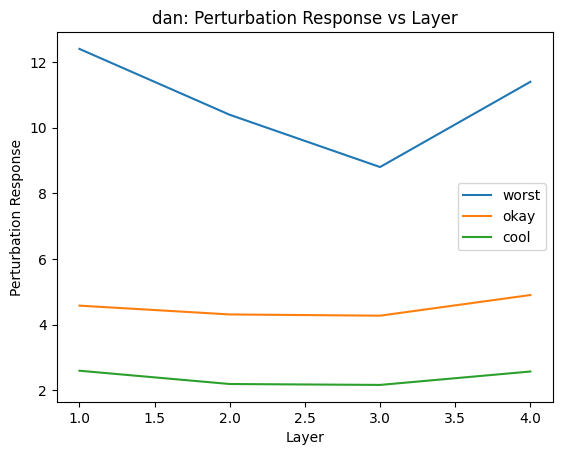

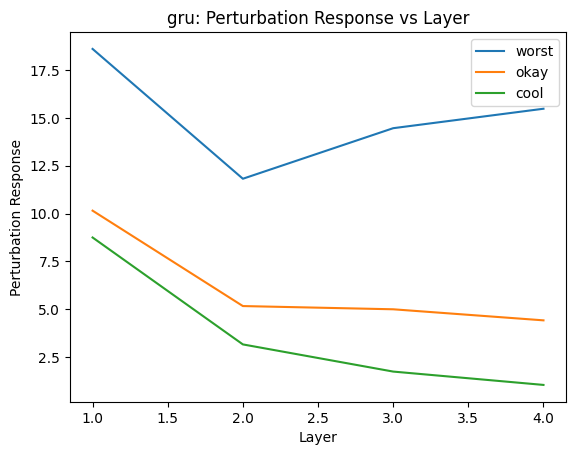

<Figure size 640x480 with 0 Axes>

In [ ]:
def perturbation_analysis():
    training_commands = []
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    choices = {"dan": range(1, 4 + 1), "gru": range(1, 4 + 1)}

    models = {"dan": None, "gru": None}
    vocabs = {"dan": None, "gru": None}
    for seq2vec_name, _ in choices.items():
        serialization_dir = os.path.join(
            "serialization_dirs", f"main_{seq2vec_name}_5k_with_emb"
        )

        vocab_path = os.path.join(serialization_dir, "vocab.txt")
        config_path = os.path.join(serialization_dir, "config.json")
        weights_path = os.path.join(serialization_dir, "model.pkg")

        model_files_present = all(
            [os.path.exists(path) for path in [vocab_path, config_path, weights_path]]
        )

        if not model_files_present:
            train_args["model_name"] = "main"
            train_args["train_data_file_path"] = imdb_sentiment_train_5k_path
            train_args["validation_data_file_path"] = f"data/imdb_sentiment_dev.jsonl"
            train_args[
                "base_model_dir"
            ] = f"serialization_dirs/main_{seq2vec_name}_5k_with_emb"
            train_args["suffix_name"] = f"_{seq2vec_name}_5k_with_emb"
            train_args["seq2vec_choice"] = seq2vec_name
            train_args["num_layers"] = 4
            train_args["num_epochs"] = 8
            print(f"Training the model with arguments:\n{train_args}")
            train_wrapper(train_args)

        model = load_pretrained_model(serialization_dir, device=device)
        models[seq2vec_name] = model

        vocab, _ = load_vocabulary(vocab_path)
        vocabs[seq2vec_name] = vocab

    if training_commands:
        print(
            "\nFirst, please finish the missing model training using the following commands:"
        )
        print("\n".join(training_commands))

    original_instance = {"text_tokens": "the film performances were awesome".split()}
    updates = ["worst", "okay", "cool"]

    updated_instances = []
    for update in updates:
        updated_instance = copy.deepcopy(original_instance)
        updated_instance["text_tokens"][4] = update
        updated_instances.append(updated_instance)
    all_instances = [original_instance] + updated_instances

    layer_representations = {}
    for seq2vec_name in choices.keys():
        model = models[seq2vec_name]
        vocab = vocabs[seq2vec_name]
        all_indexed_instances = index_instances(copy.deepcopy(all_instances), vocab)
        batches = generate_batches(all_indexed_instances, 4)
        layer_representations[seq2vec_name] = model(
            inputs=torch.Tensor(batches[0]["inputs"]).long().to(device), training=False
        )["layer_representations"]

    for seq2vec_name, representations in layer_representations.items():
        representations = np.asarray(representations.cpu().detach())
        differences_across_layers = {"worst": [], "okay": [], "cool": []}
        for layer_num in choices[seq2vec_name]:
            original_representation = representations[0, layer_num - 1, :]
            updated_representations = representations[1:, layer_num - 1, :]
            differences = [
                sum(np.abs(original_representation - updated_representation))
                for updated_representation in updated_representations
            ]
            differences_across_layers["worst"].append(float(differences[0]))
            differences_across_layers["okay"].append(float(differences[1]))
            differences_across_layers["cool"].append(float(differences[2]))

        # Make the plots
        plt.plot(
            choices[seq2vec_name], differences_across_layers["worst"], label="worst"
        )
        plt.plot(choices[seq2vec_name], differences_across_layers["okay"], label="okay")
        plt.plot(choices[seq2vec_name], differences_across_layers["cool"], label="cool")
        plt.xlabel("Layer")
        plt.ylabel("Perturbation Response")
        plt.legend()
        title = f"{seq2vec_name}: Perturbation Response vs Layer"
        plt.title(title)
        plt.savefig(os.path.join("plots", f"perturbation_response_{seq2vec_name}.png"))
        plt.show()
        plt.clf()


perturbation_analysis()

We observe that "cool" was closest to "awesome", "okay" was the next closest word, and "worst" was furthest from "awesome", in every layer, as expected. This shows that the representations of the sentence change at every layer when the last word "awesome" is perturbed, and that the representations of the sentence are most similar to "cool" than "okay", and least to "worst", which is in line with our expectations.

These observations show that both DAN and GRU models are able to capture the sentiment of the sentence, due to the abovementioned changes in the representations. There is some variation in the L1 distances across the layers within each model that might be due to the specific architecture and training dynamics of each model.


## Credits

This code was written with the help of Heeyoung Kwon, Jun Kang, Mohaddeseh Bastan, Harsh Trivedi, Matthew Matero, Nikita Soni, Sharvil Katariya, Yash Kumar Lal, Adithya V. Ganesan, Sounak Mondal, Md. Saqib Hasan, Dhruv Verma, Nishit Jain, Jasdeep Grover, and others. It is not subject to the license of this repository.
